# Credit Card Fraud Detection

In [1]:
''' Linear Algebra'''
import pandas as pd
import numpy as np

''' Data visualisation'''
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

''' Imbalanced Classes'''
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

''' Scikit-Learn'''
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix


''' Tensorflow Keras'''
from tensorflow import keras
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

2022-02-24 20:39:31.900095: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-24 20:39:31.900161: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## 1. Rebalancing classes

In [2]:
# Load data
df = pd.read_csv("creditcard.csv")

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
# Select data
X = df.drop(columns='Class', axis=1)
y= df.Class.values

In [5]:
# Let's check class balance
pd.Series(y).value_counts()

0    284315
1       492
dtype: int64

☝️ in this `fraud detection` challenge, the classes are extremely imbalanced:
* 99.8 % of normal transactions
* 0.2 % of fraudulent transactions

We won't be able to detect frauds unless we apply some serious rebalancing strategies!

❓ **Question** ❓
1. **First**, I create three separate Train/Val/Test splits from your dataset. It is extremely important to keep validation and testing sets **not rebalanced** so as to evaluate your model in true conditions without data leak. Keep your test set for the very last cell of this notebook only.

&nbsp;
2. **Second**, I rebalance you training set (and only this one). You have many choices:

- Simply oversample the minority class randomly using plain numpy functions.
- Or use <a href="https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/">Synthetic Minority Oversampling Technique</a> to generate new datapoints by weighting the existing ones
- In addition, try also <a href="https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/">RandomUnderSampler</a> to downsample a little bit the majority class

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3)

In [8]:
print(f"X_train.shape = {X_train.shape}")
print(f"y_train.shape = {y_train.shape}")
print(f"X_val.shape = {X_val.shape}")
print(f"y_val.shape = {y_val.shape}")
print(f"X_test.shape = {X_test.shape}")
print(f"y_test.shape = {y_test.shape}")

X_train.shape = (139554, 30)
y_train.shape = (139554,)
X_val.shape = (59810, 30)
y_val.shape = (59810,)
X_test.shape = (85443, 30)
y_test.shape = (85443,)


In [9]:
# How many "fraud" samples do I have in each split?

print(sum(y_train == 1))
print(sum(y_val == 1))
print(np.sum(y_test[y_test == 1]))

print("-"*100)

print(f"There are {pd.Series(y_train).value_counts()[1]} fraudulent transactions in the train set")
print(f"There are {pd.Series(y_val).value_counts()[1]} fraudulent transactions in the val set")
print(f"There are {pd.Series(y_test).value_counts()[1]} fraudulent transactions in the test set")

246
94
152
----------------------------------------------------------------------------------------------------
There are 246 fraudulent transactions in the train set
There are 94 fraudulent transactions in the val set
There are 152 fraudulent transactions in the test set


In [10]:
# Sampling strategies
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.33)

In [11]:
from sklearn import set_config;  set_config(display = 'diagram')

# Pipelining the two strategies
steps = [("0", over), ('u', under)]
pipeline = Pipeline(steps=steps)
pipeline

Pipeline(steps=[('0', SMOTE(sampling_strategy=0.1)),
                ('u', RandomUnderSampler(sampling_strategy=0.33))])

In [12]:
# Rebalance the dataset
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)

print(f"X_train_resampled.shape = {X_train_resampled.shape}")
print(f"y_train_resampled.shape = {y_train_resampled.shape}")

X_train_resampled.shape = (56142, 30)
y_train_resampled.shape = (56142,)


In [13]:
# Reshuffle the resampled data just to be sure
stacked_resampled_data = np.hstack([X_train_resampled, y_train_resampled.reshape(-1,1)])
np.random.shuffle(stacked_resampled_data)

X_train_resampled = stacked_resampled_data[:, :30]
y_train_resampled = stacked_resampled_data[:, -1]

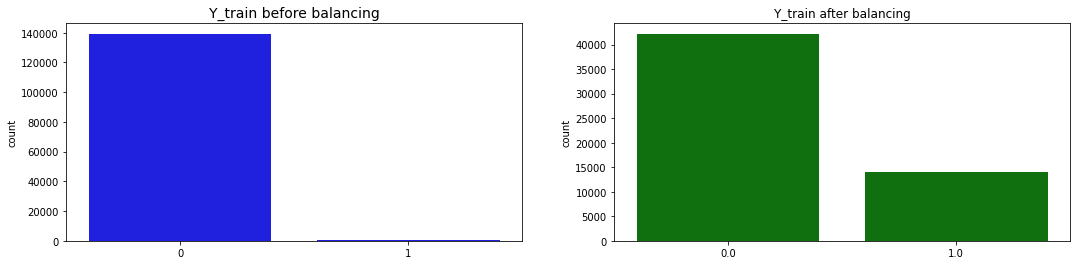

In [14]:
# plotting
warnings.filterwarnings('ignore')
fig, ax = plt.subplots(1, 2, figsize=(18, 4))

''' Before rebanlancing classes'''
sns.countplot(y_train, ax=ax[0], color='b')
ax[0].set_title("Y_train before balancing", fontsize=14)

''' After rebalancing classes'''
sns.countplot(y_train_resampled, ax=ax[1], color='g')
ax[1].set_title("Y_train after balancing");

In [15]:
print(X_train_resampled.shape)
print(X_val.shape)

(56142, 30)
(59810, 30)


## 2. Neural Network iterations

Now that I have rebalanced my classes, I will try to fit a neural network to optimize the test score. recommended hints:

- Normalize your inputs!
    - Use preferably a [`Normalization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Normalization) layer inside the model to "pipeline" your preprocessing within your model. 
    - Or use sklearn's [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) outside of your model, applied your `X_train` and `X_val` and `X_test`.
- Make model overfit, then, regularize using
    - Early Stopping criteria 
    - [`Dropout`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) layers
    - or [`regularizers`](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers) layers
- 🚨 Think carefully about the metric you want to track and the loss you want to use ?


In [16]:
metrics = [
    keras.metrics.Recall(),
    keras.metrics.Precision(),
    keras.metrics.AUC(name='prc', curve='PR')
]

2022-02-24 20:39:39.070012: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-24 20:39:39.070074: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-24 20:39:39.070094: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-BM2AJIC): /proc/driver/nvidia/version does not exist
2022-02-24 20:39:39.070303: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
# sc = StandardScaler()
def init_model():
    input_shape = X_train_resampled[1:]
    normalizer = Normalization()
    normalizer.adapt(input_shape)
    
    model = Sequential()
    model.add(normalizer)
    model.add(layers.Dense(32, activation="relu"))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(8, activation='relu'))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(1, activation='sigmoid'))
    
    
    # model compilation
    optimizer = Adam(lr=0.0001)
    model.compile(loss="binary_crossentropy",
                  optimizer=optimizer,
                 metrics=metrics)
    
    return model

### Regularized model

In [18]:
model = init_model()
model.summary()

2022-02-24 20:39:39.559258: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-24 20:39:39.559718: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2394455000 Hz


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 30)                61        
_________________________________________________________________
dense (Dense)                (None, 32)                992       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0

In [19]:
es = EarlyStopping(
    patience=10,
    monitor='val_recall', # We really want to detect fraudulent transactions!
    restore_best_weights=True)

history = model.fit(X_train_resampled, y_train_resampled,
                   validation_data=(X_val, y_val),
                   epochs=100,
                   batch_size=64, # Large enough to get a decent chance of containing fraudulent transactions
                   callbacks=[es], shuffle=True)

Epoch 1/100
878/878 [==============================] - 5s 5ms/step - loss: 0.5102 - recall: 0.5491 - precision: 0.5916 - prc: 0.6531 - val_loss: 0.1683 - val_recall: 0.7553 - val_precision: 0.4931 - val_prc: 0.6292
Epoch 2/100
878/878 [==============================] - 4s 4ms/step - loss: 0.2478 - recall: 0.7312 - precision: 0.9547 - prc: 0.9110 - val_loss: 0.0346 - val_recall: 0.7979 - val_precision: 0.5172 - val_prc: 0.6465
Epoch 3/100
878/878 [==============================] - 4s 4ms/step - loss: 0.1671 - recall: 0.8319 - precision: 0.9725 - prc: 0.9510 - val_loss: 0.0203 - val_recall: 0.8511 - val_precision: 0.4545 - val_prc: 0.6978
Epoch 4/100
878/878 [==============================] - 4s 4ms/step - loss: 0.1368 - recall: 0.8672 - precision: 0.9744 - prc: 0.9620 - val_loss: 0.0194 - val_recall: 0.8723 - val_precision: 0.3216 - val_prc: 0.7079
Epoch 5/100
878/878 [==============================] - 4s 4ms/step - loss: 0.1212 - recall: 0.8810 - precision: 0.9769 - prc: 0.9689 - val_l

In [20]:
def plot_loss_precision_recall_curve(history):
    fig, ax = plt.subplots(1,3, figsize=(20,5))
    
    # ---- Loss
    
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss', fontsize=18)
    ax[0].set_xlabel('Epoch', fontsize=14)
    ax[0].set_ylabel('Loss', fontsize=14)
    ax[0].legend(['Train', 'Val'], loc='upper right')
    ax[0].grid(axis='x', linewidth=0.5)
    ax[0].grid(axis='y', linewidth=0.5)
    
    # ---- RECALL
    
    ax[1].plot(history.history['recall'])
    ax[1].plot(history.history['val_recall'])
    ax[1].set_title('Model recall', fontsize = 18)
    ax[1].set_xlabel('Epoch', fontsize = 14)
    ax[1].set_ylabel('Recall', fontsize = 14)
    ax[1].legend(['Train', 'Val'], loc='lower right') 
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)

    
    # ---- PRECISION
    
    ax[2].plot(history.history['precision'])
    ax[2].plot(history.history['val_precision'])
    ax[2].set_title('Model precision', fontsize = 18)
    ax[2].set_xlabel('Epoch', fontsize = 14)
    ax[2].set_ylabel('Precision', fontsize = 14)
    ax[2].legend(['Train', 'Val'], loc='lower right')  
    ax[2].grid(axis="x",linewidth=0.5)
    ax[2].grid(axis="y",linewidth=0.5) 
    
    plt.show()

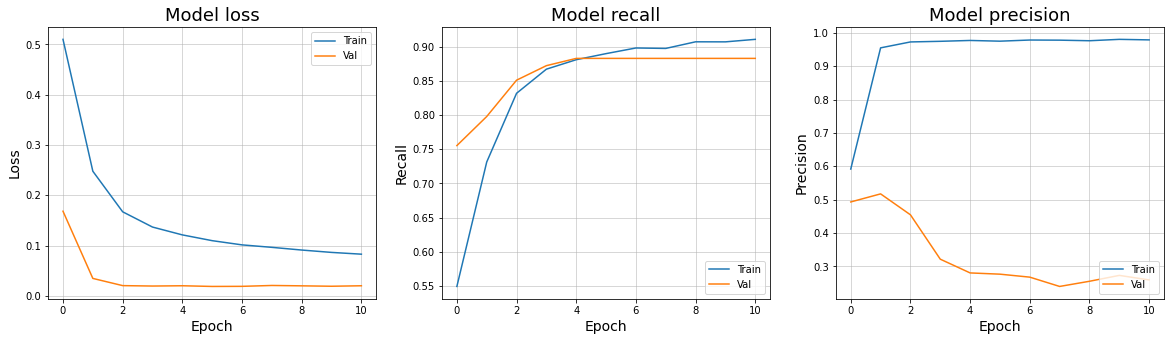

In [21]:
plot_loss_precision_recall_curve(history)

## 3. Score your model on unseen Test set

❓ **Question** ❓: Compute your confusion matrix and classification report on the test set

In [22]:
model.evaluate(X_test, y_test, verbose=0, return_dict=True)

{'loss': 0.16902242600917816,
 'recall': 0.75,
 'precision': 0.5699999928474426,
 'prc': 0.5868840217590332}

In [23]:
y_pred_proba = model.predict(X_test)

In [24]:
threshold = 0.5 # 50%
y_pred_binary = np.where(y_pred_proba > threshold, 1, 0)

### Confusion Matrix

In [25]:
cm = confusion_matrix(y_test, y_pred_binary)
cm

array([[85205,    86],
       [   38,   114]])

Text(0.5, 24.0, 'Predicted label')

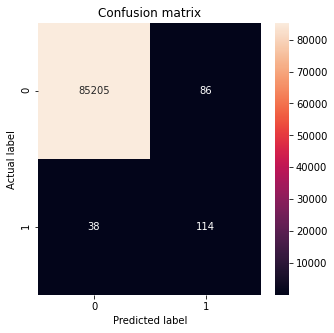

In [26]:
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [27]:
from sklearn.metrics import precision_recall_curve

def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = precision_recall_curve(labels, predictions)
    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

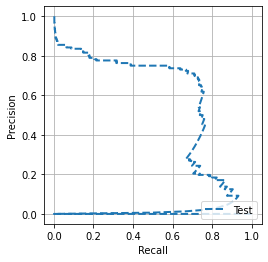

In [28]:
plot_prc("Test", y_test, y_pred_proba, linestyle='--')
plt.legend(loc='lower right')

Stored below are the real test performance on a (`X_test`, `y_test`) representative sample of the original unbalance dataset

In [29]:
precision = 0.37
recall = 0.82

## 🏁 Optional : Read Google's solution for this challenge

To conclude, here is Google's own solution direcly [on Colab here](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/imbalanced_data.ipynb). You will discover interesting techniques and best practices
